In [1]:
# importing necessary packages
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

/home/rohit/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rohit/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rohit/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rohit/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

In [2]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [3]:
# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
# reading the csv file containing the labels
data = pd.read_csv("Data_path.csv")
data.head()

,labels,source,path
0,male_happy,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/JE_h11...
1,male_angry,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/JK_a05...
2,male_neutral,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/JK_n22...
3,male_disgust,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/KL_d06...
4,male_surprise,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/DC_su1...


In [5]:
df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(data.path):
    X, sample_rate = librosa.load(path
                                  ,res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13), axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

12162


,feature
0,"[-21.379093, -21.488506, -22.79399, -21.894154..."
1,"[4.857963, 2.1802883, -2.7702487, -1.9958266, ..."
2,"[-26.060213, -23.547817, -22.635246, -18.16921..."
3,"[-21.454227, -22.888773, -27.012148, -26.95517..."
4,"[-22.758654, -18.710485, -11.95598, -9.946014,..."


In [6]:
# concatenating labeled dataframe with the extracted data
df = pd.concat([data,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_happy,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/JE_h11...,-21.379093,-21.488506,-22.793989,-21.894154,-21.031609,-22.325092,-22.793335,...,-4.781260,-4.949687,-5.400805,-5.619165,-7.750992,-11.646387,-10.565253,-6.354403,-6.787728,-5.361663
1,male_angry,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/JK_a05...,4.857963,2.180288,-2.770249,-1.995827,-0.780680,-0.125299,-0.136834,...,-27.778399,-27.038452,-26.411522,-25.299252,-25.261127,-24.063915,-24.168633,-23.207539,-23.683941,-23.100679
2,male_neutral,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/JK_n22...,-26.060213,-23.547817,-22.635246,-18.169214,-8.953858,-4.815696,-3.297021,...,-22.929493,-21.727255,-22.926390,-23.176323,-23.170887,-22.713161,-24.315762,-25.440453,-24.207241,-21.705019
3,male_disgust,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/KL_d06...,-21.454227,-22.888773,-27.012148,-26.955172,-27.943380,-30.473011,-33.364262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,male_surprise,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/DC_su1...,-22.758654,-18.710485,-11.955980,-9.946014,-8.835577,-7.678025,-5.628070,...,-10.005323,-8.823839,-9.212478,-10.346533,-14.636479,-17.771015,-17.927008,-19.199146,-3.393579,4.220823


In [7]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(12162, 219)


,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_happy,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/JE_h11...,-21.379093,-21.488506,-22.793989,-21.894154,-21.031609,-22.325092,-22.793335,...,-4.781260,-4.949687,-5.400805,-5.619165,-7.750992,-11.646387,-10.565253,-6.354403,-6.787728,-5.361663
1,male_angry,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/JK_a05...,4.857963,2.180288,-2.770249,-1.995827,-0.780680,-0.125299,-0.136834,...,-27.778399,-27.038452,-26.411522,-25.299252,-25.261127,-24.063915,-24.168633,-23.207539,-23.683941,-23.100679
2,male_neutral,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/JK_n22...,-26.060213,-23.547817,-22.635246,-18.169214,-8.953858,-4.815696,-3.297021,...,-22.929493,-21.727255,-22.926390,-23.176323,-23.170887,-22.713161,-24.315762,-25.440453,-24.207241,-21.705019
3,male_disgust,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/KL_d06...,-21.454227,-22.888773,-27.012148,-26.955172,-27.943380,-30.473011,-33.364262,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male_surprise,SAVEE,/home/rohit/Desktop/audio_emotion/SAVEE/DC_su1...,-22.758654,-18.710485,-11.955980,-9.946014,-8.835577,-7.678025,-5.628070,...,-10.005323,-8.823839,-9.212478,-10.346533,-14.636479,-17.771015,-17.927008,-19.199146,-3.393579,4.220823


In [8]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels, test_size=0.25, shuffle=True, random_state=42)

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,-18.611181,-17.616537,-18.411484,-18.987421,-17.404621,-16.747271,-17.733747,-18.055027,-17.931210,-15.913171,...,-22.899401,-21.647814,-19.758650,-18.879402,-19.397379,-20.171659,-22.689241,-24.612816,-24.153774,-22.703135
3860,-12.879316,-16.401539,-19.268156,-17.284307,-16.488289,-16.603512,-19.190636,-21.131804,-22.313334,-25.600109,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9761,-1.533948,-4.030604,-9.614023,-12.045173,-9.992991,-11.926252,-14.008467,-13.561554,-14.024568,-15.151947,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7620,-4.531077,-3.933794,-4.567834,-5.871509,-5.282473,-6.490458,-8.156468,-9.188803,-8.681728,-8.212411,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11586,-20.621702,-21.587507,-20.563650,-20.703461,-21.205717,-18.608528,-18.446669,-16.211845,-14.257653,-15.160404,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7914,-17.514992,-18.551868,-17.043013,-16.977903,-19.369631,-19.562130,-22.008749,-20.178379,-17.989595,-19.336285,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9513,-18.740368,-18.824932,-16.149492,-16.963455,-18.229977,-18.183958,-19.274342,-18.395124,-16.951286,-16.672031,...,-17.882132,-19.390709,-17.779476,-19.165974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5835,-19.066851,-18.328384,-17.710285,-18.043194,-18.252481,-18.710625,-16.626352,-17.831005,-18.028343,-17.859104,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5389,-20.760588,-20.047142,-18.961346,-19.468687,-19.316296,-18.162565,-18.102333,-19.914131,-20.931385,-19.215494,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11222,-18.252928,-17.727369,-19.222475,-18.469973,-17.572327,-17.850544,-17.932026,-20.588900,-18.612183,-15.990723,...,-18.065437,-18.135088,-19.665306,-20.741903,-20.273033,-18.371031,-15.576723,-17.512487,-17.008549,-18.195280


In [9]:
# Lets do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,0.185184,0.301077,0.435292,0.386028,0.496086,0.540143,0.459696,0.431361,0.434791,0.579578,...,-0.870493,-0.803186,-0.684144,-0.622786,-0.667886,-0.710218,-0.852568,-0.975288,-0.958998,-0.869832
3860,0.584632,0.389116,0.371849,0.511869,0.563653,0.550737,0.352539,0.205117,0.112907,-0.131150,...,0.541633,0.527992,0.527432,0.528235,0.513585,0.513572,0.514058,0.502042,0.497023,0.492859
9761,1.375280,1.285512,1.086809,0.898981,1.042591,0.895418,0.733698,0.761778,0.721749,0.635428,...,0.541633,0.527992,0.527432,0.528235,0.513585,0.513572,0.514058,0.502042,0.497023,0.492859
7620,1.166413,1.292527,1.460517,1.355145,1.389926,1.295997,1.164123,1.083319,1.114201,1.144580,...,0.541633,0.527992,0.527432,0.528235,0.513585,0.513572,0.514058,0.502042,0.497023,0.492859
11586,0.045073,0.013341,0.275908,0.259232,0.215808,0.402981,0.407259,0.566895,0.704628,0.634808,...,0.541633,0.527992,0.527432,0.528235,0.513585,0.513572,0.514058,0.502042,0.497023,0.492859
7914,0.261576,0.233303,0.536637,0.534508,0.351194,0.332708,0.145262,0.275225,0.430502,0.328425,...,0.541633,0.527992,0.527432,0.528235,0.513585,0.513572,0.514058,0.502042,0.497023,0.492859
9513,0.176181,0.213517,0.602809,0.535576,0.435227,0.434269,0.346383,0.406353,0.506770,0.523900,...,-0.561095,-0.664391,-0.562783,-0.640257,0.513585,0.513572,0.514058,0.502042,0.497023,0.492859
5835,0.153429,0.249497,0.487221,0.455796,0.433568,0.395458,0.541147,0.447834,0.427656,0.436805,...,0.541633,0.527992,0.527432,0.528235,0.513585,0.513572,0.514058,0.502042,0.497023,0.492859
5389,0.035394,0.124956,0.394571,0.350468,0.355126,0.435846,0.432586,0.294656,0.214416,0.337287,...,0.541633,0.527992,0.527432,0.528235,0.513585,0.513572,0.514058,0.502042,0.497023,0.492859
11222,0.210150,0.293046,0.375232,0.424261,0.483720,0.458839,0.445112,0.245038,0.384771,0.573888,...,-0.572399,-0.587180,-0.678420,-0.736337,-0.721221,-0.600976,-0.424165,-0.549107,-0.528274,-0.599261


In [11]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
print(y_train[0:10])
print(y_test[0:10])

(9121, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0.

In [12]:
# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

In [13]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(9121, 216, 1)

In [43]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [44]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 216, 256)          2304      
_________________________________________________________________
activation_19 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization_5 (Batch (None, 216, 256)          1024      
_________________________________________________________________
activation_20 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 27, 256)          

In [45]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

Train on 9121 samples, validate on 3041 samples
Epoch 1/50
9121/9121 [==============================] - 252s 28ms/step - loss: 2.5224 - accuracy: 0.1466 - val_loss: 2.6369 - val_accuracy: 0.0901
Epoch 2/50
9121/9121 [==============================] - 240s 26ms/step - loss: 2.3795 - accuracy: 0.1943 - val_loss: 2.5542 - val_accuracy: 0.1424
Epoch 3/50
9121/9121 [==============================] - 226s 25ms/step - loss: 2.3081 - accuracy: 0.2113 - val_loss: 2.4275 - val_accuracy: 0.1713
Epoch 4/50
9121/9121 [==============================] - 226s 25ms/step - loss: 2.2543 - accuracy: 0.2218 - val_loss: 2.4171 - val_accuracy: 0.1628
Epoch 5/50
9121/9121 [==============================] - 227s 25ms/step - loss: 2.2123 - accuracy: 0.2345 - val_loss: 2.4153 - val_accuracy: 0.1671
Epoch 6/50
9121/9121 [==============================] - 226s 25ms/step - loss: 2.1657 - accuracy: 0.2484 - val_loss: 2.4127 - val_accuracy: 0.1736
Epoch 7/50
9121/9121 [==============================] - 231s 25ms/step

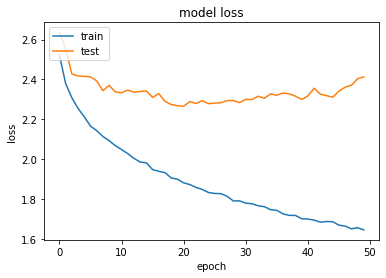

In [56]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /home/rohit/Desktop/audio_emotion/saved_models/Emotion_Model.h5 


In [58]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 20.16%


In [59]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

3041/3041 [==============================] - 22s 7ms/step


array([4, 3, 8, ..., 4, 1, 8])

In [60]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,male_sad,female_disgust
171,female_fear,female_fear
172,male_angry,male_neutral
173,female_disgust,female_sad
174,male_angry,male_happy
175,female_fear,male_happy
176,male_happy,male_angry
177,female_fear,female_fear
178,female_happy,female_fear
179,female_neutral,female_happy


In [61]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,64
female_disgust,445
female_fear,580
female_happy,398
female_neutral,303
female_sad,382
female_surprise,48
male_angry,42
male_disgust,103


In [62]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

0.20157842814863533


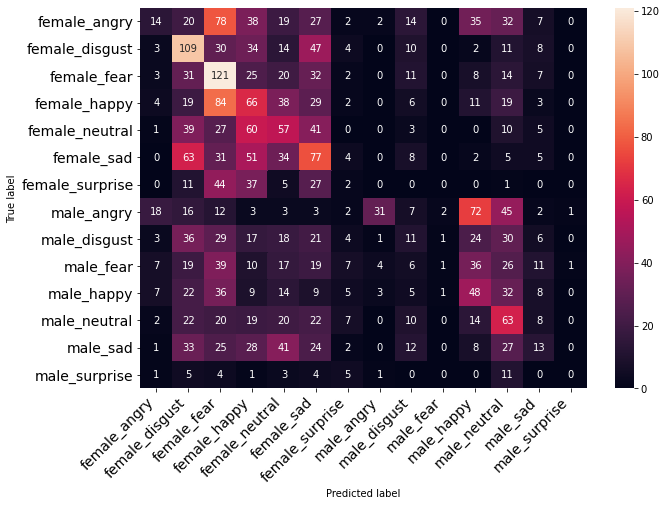

In [63]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

The model gave an accuracy of 20.15%. The model predicts the emotion seperated for male and female. 

In [64]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.22      0.05      0.08       288
 female_disgust       0.24      0.40      0.30       272
    female_fear       0.21      0.44      0.28       274
   female_happy       0.17      0.23      0.19       281
 female_neutral       0.19      0.23      0.21       243
     female_sad       0.20      0.28      0.23       280
female_surprise       0.04      0.02      0.02       127
     male_angry       0.74      0.14      0.24       217
   male_disgust       0.11      0.05      0.07       201
      male_fear       0.20      0.00      0.01       203
     male_happy       0.18      0.24      0.21       199
   male_neutral       0.19      0.30      0.24       207
       male_sad       0.16      0.06      0.09       214
  male_surprise       0.00      0.00      0.00        35

       accuracy                           0.20      3041
      macro avg       0.20      0.18      0.16      3041
   weighted avg       0.22   

#### The classification report showing the precision, recall and F1-score of the emotion class

0.6931930286090102


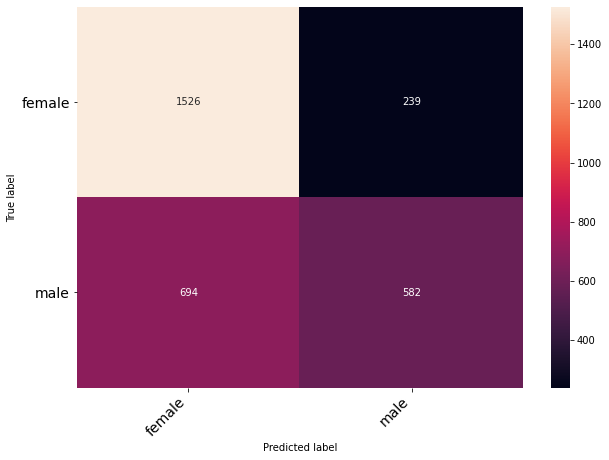

In [65]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)



#### The model is able to differentiate the gender in the audio file with an accuracy of 69.31%

In [66]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.69      0.86      0.77      1765
        male       0.71      0.46      0.56      1276

    accuracy                           0.69      3041
   macro avg       0.70      0.66      0.66      3041
weighted avg       0.70      0.69      0.68      3041



0.2637290365011509


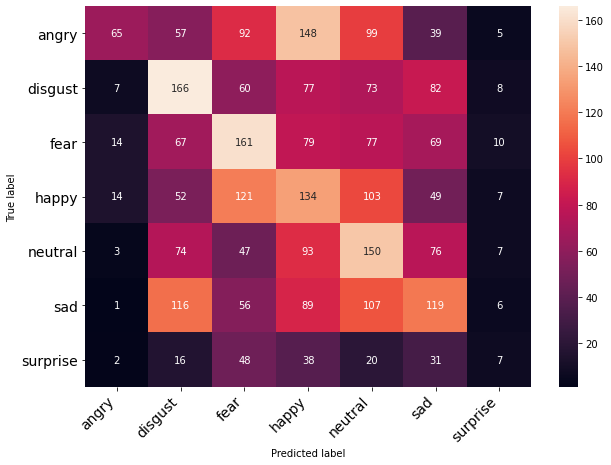

In [67]:


modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)



#### The model was able to classify emotion(with no gender seperation) with an accuracy of 26.37%  

In [68]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.61      0.13      0.21       505
     disgust       0.30      0.35      0.33       473
        fear       0.28      0.34      0.30       477
       happy       0.20      0.28      0.24       480
     neutral       0.24      0.33      0.28       450
         sad       0.26      0.24      0.25       494
    surprise       0.14      0.04      0.07       162

    accuracy                           0.26      3041
   macro avg       0.29      0.24      0.24      3041
weighted avg       0.31      0.26      0.26      3041



#   

#    

### OBSERVATION

1) The model was able to learn something from the feature extracted. It being a baseline model did not give a high performance. The accuracy is 20.15%. One thing to note is that the model tried understand the emotion and did not classify everything to be of a certain class. The precision, recall and F1-score of most of the classes were similar except for one class.

2) The model was able to differentiate gender using the features with an accuracy of 69.31%. The model performed a little better for Female gender classification when compared with male gender.

3) When not considering the gender, the model was giving an accuracy score of 26.37%. THe performance of each class was similar except for one class.